# Solar energy - Power plant Predictions for one region - part 3-3 
---
In [the previous part](https://www.kaggle.com/obrunet/exploratory-data-analysis-part-2-3) of this study we've have made an exploratory analysis of the data set. We were able to understand how solar generation is dependant of time. Now in this final step, we're going to training different types of machine learning models in order to make predictions.


For that, we'll only keep one region 'FR10' corresponding to the Paris Area.

## Data preparation

As usual, let's start with some data preparation : first we import the needed libraries, then we import the csv file into a dataframe. After that we can reuse a previous function to add date time informations (year, month, week of the year, the day of the year, and the hour of the day):

In [1]:
# data manipulation
import numpy as np
import pandas as pd

# for plotting purposes
import seaborn as sns
import matplotlib.pyplot as plt

# options
pd.options.display.max_columns = 300

import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv("solar_generation_by_station.csv")


def add_date_time(_df):
    "Returns a DF with two new cols : the time and hour of the day"
    t = pd.date_range(start='1/1/1986', periods=_df.shape[0], freq = 'H')
    t = pd.DataFrame(t)
    _df = pd.concat([_df, t], axis=1)
    _df.rename(columns={ _df.columns[-1]: "time" }, inplace = True)
    _df['year'] = _df['time'].dt.year
    _df['month'] = _df['time'].dt.month
    _df['week'] = _df['time'].dt.weekofyear
    _df['day'] = _df['time'].dt.dayofyear    
    _df['hour'] = _df['time'].dt.hour
    return _df

Let's keep only non leap years that cause problems for time series (because of the number of days in a year varies) :

In [2]:
df = add_date_time(df)
df = df[~df.year.isin([1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016])]

# keeping only values for one country for the predictions
df = df[['FR10', 'year', 'month', 'week', 'day', 'hour', 'time']]
df.head(2)

,FR10,year,month,week,day,hour,time
0,0.0,1986,1,1,1,0,1986-01-01 00:00:00
1,0.0,1986,1,1,1,1,1986-01-01 01:00:00


Number of rows and colums kepts :

In [3]:
df.shape

(201480, 7)

__As usual, separation of the data set into 2 disctinct sets :__

In machine learning, a common task is the study and construction of algorithms that can learn from and make predictions on data. Such algorithms work by making data-driven predictions or decisions, through building a mathematical model from input data.

The data used to build the final model usually comes from multiple datasets. In particular, two data sets are commonly used in different stages of the creation of the model.

The model is initially fit on a training dataset,that is a set of examples used to fit the parameters of the model. The model is trained on the training dataset using a supervised learning method.

Finally, the test dataset is a dataset used to provide an unbiased evaluation of a final model fit on the training dataset. If the data in the test dataset has never been used in training , the test dataset is also called a holdout dataset.

Reference : [Wikipedia](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets)

In [4]:
# train data including 10 years of records except the last month
train_data = df[-24*365*10:-24*31]

# test data = last month of records for year 2015
test_data = df[-24*31:]

---
# Model Training

## Metric : RMSE

The root-mean-square error (RMSE) is a frequently used measure of the differences between values (sample or population values) predicted by a model or an estimator and the values observed. The RMSE represents the square root of the second sample moment of the differences between predicted values and observed values or the quadratic mean of these differences. These deviations are called residuals when the calculations are performed over the data sample that was used for estimation and are called errors (or prediction errors) when computed out-of-sample. The RMSE serves to aggregate the magnitudes of the errors in predictions for various times into a single measure of predictive power. RMSE is a measure of accuracy, to compare forecasting errors of different models for a particular dataset and not between datasets, as it is scale-dependent.

RMSE is always non-negative, and a value of 0 (almost never achieved in practice) would indicate a perfect fit to the data. In general, a lower RMSE is better than a higher one. However, comparisons across different types of data would be invalid because the measure is dependent on the scale of the numbers used.

RMSE is the square root of the average of squared errors. The effect of each error on RMSE is proportional to the size of the squared error; thus larger errors have a disproportionately large effect on RMSE. Consequently, RMSE is sensitive to outliers.

Any way we've already seen in the previous part that there isn't any outlier, so we can definitively use the RMSE as a metric to compare models accuracies.

Reference : [Wikipedia](https://en.wikipedia.org/wiki/Root-mean-square_deviation)

In [5]:
from sklearn.metrics import mean_squared_error
model_instances, model_names, rmse_train, rmse_test = [], [], [], []


def plot_scores():
    """Create three lists : models, the RMSE on the train set and on the test set, then plot them"""
    df_score = pd.DataFrame({'model_names' : model_names,
                             'rmse_train' : rmse_train,
                             'rmse_test' : rmse_test})
    df_score = pd.melt(df_score, id_vars=['model_names'], value_vars=['rmse_train', 'rmse_test'])

    plt.figure(figsize=(12, 10))
    sns.barplot(y="model_names", x="value", hue="variable", data=df_score)
    plt.show()

## Baseline

This simple model use the mean of 10 years at a certain day at a specific hour. It can be considered as a weak predicator. It is used to see if the other ML models are interesting and efficient or not. Let's see how the predictions of this baseline look like :

In [6]:
x_train, y_train = train_data.drop(columns=['time']), train_data['FR10']
x_test, y_test = test_data.drop(columns=['time']), test_data['FR10']


def mean_df(d, h):
    "return the hourly mean of a specific day of the year"
    res = x_train[(x_train['day'] == d) & (x_train['hour'] == h)]['FR10'].mean()
    return res

    # examples 
    #df['col_3'] = df.apply(lambda x: f(x.col_1, x.col_2), axis=1)
    # x_train[(x_train['day'] == x['day']) & (x_train['hour'] == x['hour'])]['FR10'].mean()
    
    
#x_train['pred'] = x_train.apply(lambda x: mean_df(x.day, x.hour), axis=1)
x_test['pred'] = x_test.apply(lambda x: mean_df(x.day, x.hour), axis=1)
x_test.head()

,FR10,year,month,week,day,hour,pred
262224,0.0,2015,12,49,335,0,0.0
262225,0.0,2015,12,49,335,1,0.0
262226,0.0,2015,12,49,335,2,0.0
262227,0.0,2015,12,49,335,3,0.0
262228,0.0,2015,12,49,335,4,0.0


Let's add the result to our lists of models and RMSE for both the train & test sets :

In [7]:
model_names.append("base_line")
rmse_train.append(np.sqrt(mean_squared_error(x_train['FR10'], x_train['FR10']))) # a modifier en pred
rmse_test.append(np.sqrt(mean_squared_error(x_test['FR10'], x_test['pred'])))

Now we can plot the variation of the real values and the predicted ones across hours in order to understand how th model behaves (predictions are in orange and ground truth in blue) :

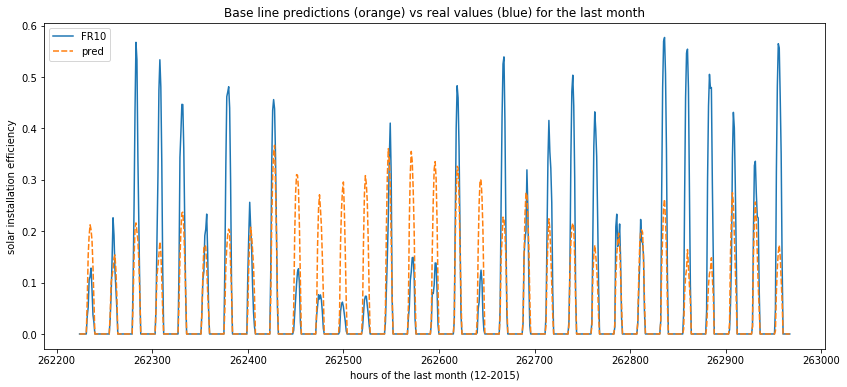

In [8]:
def plot_predictions(data):
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=data)
    plt.title("Base line predictions (orange) vs real values (blue) for the last month")
    plt.xlabel("hours of the last month (12-2015)")
    plt.ylabel("solar installation efficiency")
    plt.show()

plot_predictions(data=x_test[['FR10', 'pred']])

## Regression models

At first we are goiing to use the basic linear regression models : LinearRegression, Ridge, Lasso, ElasticNet. Note that last three use different kind of regularizations.

In [9]:
X_train, y_train = train_data[['month', 'week', 'day', 'hour']], train_data['FR10']
X_test, y_test = test_data[['month', 'week', 'day', 'hour']], test_data['FR10']
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((86856, 4), (86856,), (744, 4), (744,))

In [10]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR

import xgboost as xgb
import lightgbm as lgbm


def get_rmse(reg, model_name):
    """Print the score for the model passed in argument and retrun scores for the train/test sets"""
    
    y_train_pred, y_pred = reg.predict(X_train), reg.predict(X_test)
    rmse_train, rmse_test = np.sqrt(mean_squared_error(y_train, y_train_pred)), np.sqrt(mean_squared_error(y_test, y_pred))
    print(model_name, f'\t - RMSE on Training  = {rmse_train:.2f} / RMSE on Test = {rmse_test:.2f}')
    
    return rmse_train, rmse_test


# list of all the basic models used at first
model_list = [
    LinearRegression(), Lasso(), Ridge(), ElasticNet(),
    RandomForestRegressor(), GradientBoostingRegressor(), ExtraTreesRegressor(),
    xgb.XGBRegressor(), lgbm.LGBMRegressor(), KNeighborsRegressor()
             ]

# creation of list of names and scores for the train / test
model_names.extend([str(m)[:str(m).index('(')] for m in model_list])


# fit and predict all models
for model, name in zip(model_list, model_names):
    model.fit(X_train, y_train)
    sc_train, sc_test = get_rmse(model, name)
    rmse_train.append(sc_train)
    rmse_test.append(sc_test)

base_line 	 - RMSE on Training  = 0.21 / RMSE on Test = 0.15
LinearRegression 	 - RMSE on Training  = 0.21 / RMSE on Test = 0.15
Lasso 	 - RMSE on Training  = 0.21 / RMSE on Test = 0.15
Ridge 	 - RMSE on Training  = 0.21 / RMSE on Test = 0.15
ElasticNet 	 - RMSE on Training  = 0.10 / RMSE on Test = 0.10
RandomForestRegressor 	 - RMSE on Training  = 0.11 / RMSE on Test = 0.09
GradientBoostingRegressor 	 - RMSE on Training  = 0.10 / RMSE on Test = 0.10
ExtraTreesRegressor 	 - RMSE on Training  = 0.11 / RMSE on Test = 0.09
XGBRegressor 	 - RMSE on Training  = 0.10 / RMSE on Test = 0.10
LGBMRegressor 	 - RMSE on Training  = 0.10 / RMSE on Test = 0.10


## SVM model

the Support Vector Machine (both linear and poly kernels) aren't efficient enough :

Side note : this model is CPU or GPU intensive so i've decided to print the code and results in order to not re-excute all this part but if you want, you can easily re-run the following code

In [11]:
print("""
svm_lin = LinearSVR()
svm_lin.fit(X_train, y_train)
sc_train, sc_test = get_rmse(svm_lin, "SVM lin.")
model_names.append("SVM lin.")
rmse_train.append(sc_train)
rmse_test.append(sc_test)

SVM lin. 	 - RMSE on Training  = 0.31 / RMSE on Test = 0.30
""")


svm_lin = LinearSVR()
svm_lin.fit(X_train, y_train)
sc_train, sc_test = get_rmse(svm_lin, "SVM lin.")
model_names.append("SVM lin.")
rmse_train.append(sc_train)
rmse_test.append(sc_test)

SVM lin. 	 - RMSE on Training  = 0.31 / RMSE on Test = 0.30



In [12]:
print("""
svm_poly = SVR(kernel='poly', degree=4, max_iter=100)
svm_poly.fit(X_train, y_train)
sc_train, sc_test = get_rmse(svm_poly, "SVM poly.")
model_names.append("SVM poly.")
rmse_train.append(sc_train)
rmse_test.append(sc_test)

SVM poly. 	 - RMSE on Training  = 0.52 / RMSE on Test = 0.56
""")


svm_poly = SVR(kernel='poly', degree=4, max_iter=100)
svm_poly.fit(X_train, y_train)
sc_train, sc_test = get_rmse(svm_poly, "SVM poly.")
model_names.append("SVM poly.")
rmse_train.append(sc_train)
rmse_test.append(sc_test)

SVM poly. 	 - RMSE on Training  = 0.52 / RMSE on Test = 0.56



## Using polynomial feature

If we use the "polynomial features" method of scikit learn to elevate date time infos to different powers :

In [13]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline


poly_lin_reg = Pipeline([
    ("poly_feat", PolynomialFeatures(degree=4)),
    ("linear_reg", LinearRegression())
])

poly_lin_reg.fit(X_train, y_train)

sc_train, sc_test = get_rmse(poly_lin_reg, "Poly Linear Reg")

model_names.append('Poly Linear Reg')
rmse_train.append(sc_train)
rmse_test.append(sc_test)

Poly Linear Reg 	 - RMSE on Training  = 0.12 / RMSE on Test = 0.11


## Treating date time infos as categorical features

Now let's try to deal with date time infos as categorical featues, which is some times the right way to handle such data :

In [14]:
# train data for 10 years
train_data_d = df[-24*365*10:][['FR10', 'month', 'week', 'day', 'hour']]

# one hot encoding for categorical feature
cat_feat = ['month', 'week', 'day', 'hour']
train_data_d = pd.get_dummies(data=train_data_d, columns=cat_feat, drop_first=True)
train_data_d.head()

# keep last month for the test data set
test_data_d, train_data_d = train_data_d[-24*31:], train_data_d[:-24*31]

# get_dummies or one hot encoding
X_train_d, y_train_d = train_data_d.drop(columns=['FR10']), train_data_d['FR10']
X_test_d, y_test_d = test_data_d.drop(columns=['FR10']), test_data_d['FR10']

# verify if different shapes match
X_train_d.shape, y_train_d.shape, X_test_d.shape, y_test_d.shape

((86856, 450), (86856,), (744, 450), (744,))

In [15]:
categorical_linreg = LinearRegression()
categorical_linreg.fit(X_train, y_train)
sc_train, sc_test = get_rmse(categorical_linreg, "Categorical lin. reg.")
print("Not more efficient than linear regression without get dummies")

Categorical lin. reg. 	 - RMSE on Training  = 0.21 / RMSE on Test = 0.15
Not more efficient than linear regression without get dummies


## How does the best model behave 
Now we plot the predictions from the GradientBoostingRegressor which seems to be the best model so far. As you can see, the stricly positive values corresponding to hours of sun light are in the right "tempo" compared to the ground truth. But the spikes are nearly all the same because there is a daily variation that can't be handled by the model.

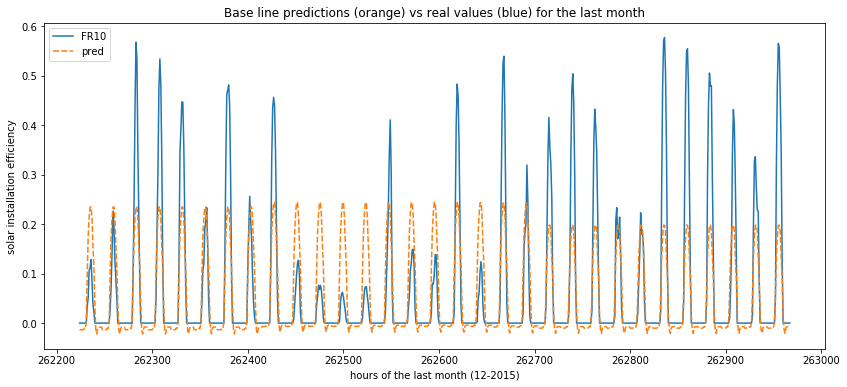

In [16]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
y_pred = pd.DataFrame(gbr.predict(X_test))

y_test = pd.DataFrame(y_test)
y_test['pred'] = y_pred.values

plot_predictions(data=y_test)

---
# Prophet - a facebook lib for time series

Let's try something different : a library specific for time series.
I've decided to use prophet, but one can also give an opportunity to other libs such as ARIMA / SARIMA.

_[...]Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.[...]_

As mentionned in the documentation :

_[...]Prophet follows the sklearn model API. We create an instance of the Prophet class and then call its fit and predict methods. The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.[...]_

Reference : [Prophet](https://facebook.github.io/prophet/)

In [17]:
# reload the data
df = pd.read_csv("solar_generation_by_station.csv")
df = add_date_time(df)
#df = df[~df.year.isin([1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016])]


# only keep what it usefull to use here
data = df[['time', 'FR10']]
data = data.rename(columns={"time": "ds", "FR10": "y"})

# train set : 10 yrs. except last month
train_data = data[-24*365*10:-24*31]

# test set = last month of the record (2015)
test_data = data[-24*31:]

import the prophet library, initialize model and fit it :

In [18]:
from fbprophet import Prophet

prophet_model = Prophet()
prophet_model.fit(train_data)
test_data.tail()
#y_train_pred = prophet_model.predict(train_data)

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


,ds,y
262963,2015-12-31 19:00:00,0.0
262964,2015-12-31 20:00:00,0.0
262965,2015-12-31 21:00:00,0.0
262966,2015-12-31 22:00:00,0.0
262967,2015-12-31 23:00:00,0.0


Use our trained model to make predictions :

In [19]:
forecast = prophet_model.predict(test_data)
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast['FR10'] = test_data['y'].values
forecast.tail()

,ds,yhat,yhat_lower,yhat_upper,FR10
739,2015-12-31 19:00:00,-0.082307,-0.235853,0.084162,0.0
740,2015-12-31 20:00:00,-0.077637,-0.234622,0.075129,0.0
741,2015-12-31 21:00:00,-0.071139,-0.236347,0.077134,0.0
742,2015-12-31 22:00:00,-0.073426,-0.222571,0.076136,0.0
743,2015-12-31 23:00:00,-0.080386,-0.233881,0.072340,0.0


- "prophet" : is the forecast
- "prophet_lower" : corresponds to the lower forecast
- "prophet_upper" : same thing but upper forecast

In the same way, it is usefull to visualize the predictions. As you can see on the plot below, the timing of predictions seems to be fine, but some negative values are forecast and the spikes are all the same once again.

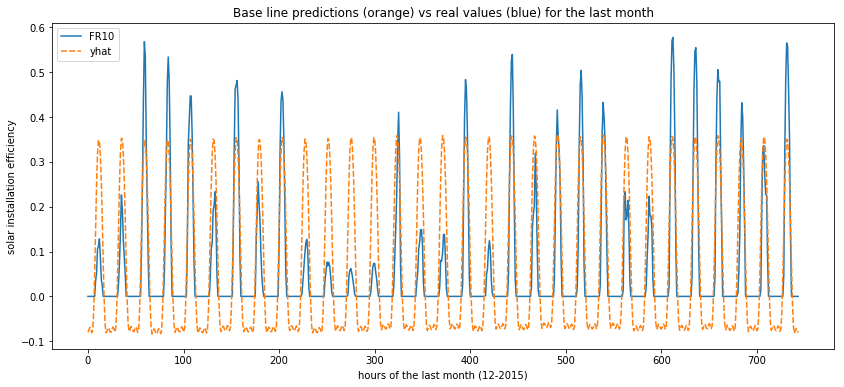

In [20]:
model_names.append("prophet") #.extend(["prophet", "prophet_lower", "prophet_upper"])

rmse_train.append(0)
#rmse_train.extend([0, 0, 0])
rmse_test.append(np.sqrt(mean_squared_error(test_data['y'], forecast['yhat'])))
#rmse_test.append(np.sqrt(mean_squared_error(test_data['y'], forecast['yhat_lower'])))
#rmse_test.append(np.sqrt(mean_squared_error(test_data['y'], forecast['yhat_upper'])))


plot_predictions(data=forecast[['FR10', 'yhat']])

# if we wanted to plot aslo inf / sup
# plt.figure(figsize=(18, 8))
# sns.lineplot(data=forecast[['FR10', 'yhat_lower', 'yhat_upper']])

Side note : prophet seems to be a powerfull library and can certainly be tuned to obtain better forecast. Here is just a first taste so please consider reading the doc and using advanced features.

---
# Using deep learning R.N.N models

In this final step, we're going to train deep learning models and especialy Recurrent neural network

In [21]:
df = pd.read_csv("solar_generation_by_station.csv")
df = df[sorted([c for c in df.columns if 'FR' in c])]

# keep only 4 years
df = df[-24*365*4:]

# nb lines / cols
df.shape

(35040, 22)

## Data preparation

We make a prediction of the FR10 value of a specific hour, based on all the features (all other regions' efficiencies) of the past 2 days (48 hrs).

Before doing so, we need to create the (X, y) dataset.

Let's consider your action Name has 100 lines.
The X values should contain, in each line, a table of 48 hrs and 22 features. So that the final X array will have the shape ((100-48+1), 48, 22).

The corresponding y values should be the station efficiency of the hours 49 (indeed, y can not contain the 48 first hours, since we need 2 days of X to predict before). So the final y array will have the shape ((100-48+1), 1) (or equivalently (53,)).

In [22]:
def process_data(data, past):
    X = []
    for i in range(len(data)-past-1):
        X.append(data.iloc[i:i+past].values)
    return np.array(X)


lookback = 48

y = df['FR10'][lookback+1:] 
X = process_data(df, lookback)
X.shape, y.shape

((34991, 48, 22), (34991,))

We don't need to scale the values since they are already between 0 and 1. So let's start by building a simple RNN model. Before we need to split the data set in two parts for training and test purposes. We can use the parameter shuffle=False in the scikit learn train_test_split method so that the last 20% will correspond to the end of our hourly records and not randomly choosen lines of the dataframe.

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((27992, 48, 22), (6999, 48, 22), (27992,), (6999,))

## R.N.N Recurrent neural network

A recurrent neural network (RNN) is a class of artificial neural networks where connections between nodes form a directed graph along a temporal sequence. This allows it to exhibit temporal dynamic behavior. Unlike feedforward neural networks, RNNs can use their internal state (memory) to process sequences of inputs. 

Reference : [Wikipedia](https://en.wikipedia.org/wiki/Recurrent_neural_network)

More infos can be found here on [Towards Data Science](https://towardsdatascience.com/recurrent-neural-networks-d4642c9bc7ce)

After the libraries import, we build a RNN with Tensorflow, we compile and train it :

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, Dropout


def my_RNN():
    my_rnn = Sequential()
    my_rnn.add(SimpleRNN(units=32, return_sequences=True, input_shape=(lookback,22)))
    my_rnn.add(SimpleRNN(units=32, return_sequences=True))
    my_rnn.add(SimpleRNN(units=32, return_sequences=False))
    my_rnn.add(Dense(units=1, activation='linear'))
    return my_rnn


rnn_model = my_RNN()
rnn_model.compile(optimizer='adam', loss='mean_squared_error')
rnn_model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


Train on 27992 samples, validate on 6999 samples
Epoch 1/50
27992/27992 [==============================] - 8s 292us/sample - loss: 0.0106 - val_loss: 0.0062
Epoch 2/50
27992/27992 [==============================] - 7s 232us/sample - loss: 0.0054 - val_loss: 0.0067
Epoch 3/50
27992/27992 [==============================] - 7s 238us/sample - loss: 0.0049 - val_loss: 0.0051
Epoch 4/50
27992/27992 [==============================] - 7s 240us/sample - loss: 0.0045 - val_loss: 0.0044
Epoch 5/50
27992/27992 [==============================] - 6s 231us/sample - loss: 0.0043 - val_loss: 0.0043
Epoch 6/50
27992/27992 [==============================] - 7s 237us/sample - loss: 0.0040 - val_loss: 0.0042
Epoch 7/50
27992/27992 [==============================] - 6s 231us/sample - loss: 0.0039 - val_loss: 0.0051
Epoch 8/50
27992/27992 [==============================] - 7s 232us/sample - loss: 0.0036 - val_loss: 0.0037
Epoch 9/50
27992/27992 [==============================] - 7s 234us/sample - loss: 0.003

Then let's use our trained RNN model to make prediction and see the RMSE not bad isn't it ?

In [25]:
y_pred_train, y_pred_test = rnn_model.predict(X_train), rnn_model.predict(X_test)
err_train, err_test = np.sqrt(mean_squared_error(y_train, y_pred_train)), np.sqrt(mean_squared_error(y_test, y_pred_test))
err_train, err_test

(0.04996607150422412, 0.05439772481791008)

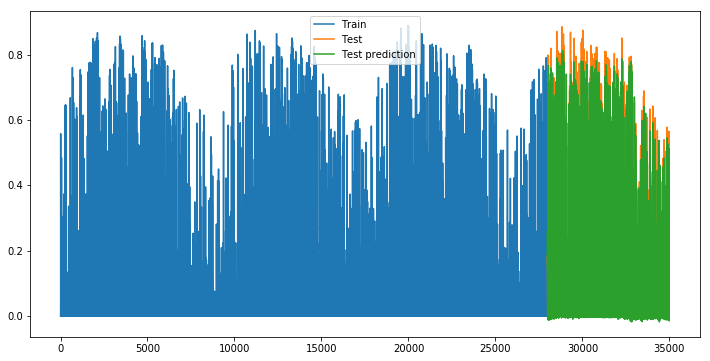

In [26]:
def append_results(model_name):
    model_names.append(model_name)
    rmse_train.append(err_train)
    rmse_test.append(err_test)

append_results("RNN")


def plot_evolution():
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(X_train)), y_train, label='Train')
    plt.plot(np.arange(len(X_train), len(X_train)+len(X_test), 1), y_test, label='Test')
    plt.plot(np.arange(len(X_train), len(X_train)+len(X_test), 1), y_pred_test, label='Test prediction')
    plt.legend()
    plt.show()

plot_evolution()

If we look at the predictions versus ground truth, this is much better !

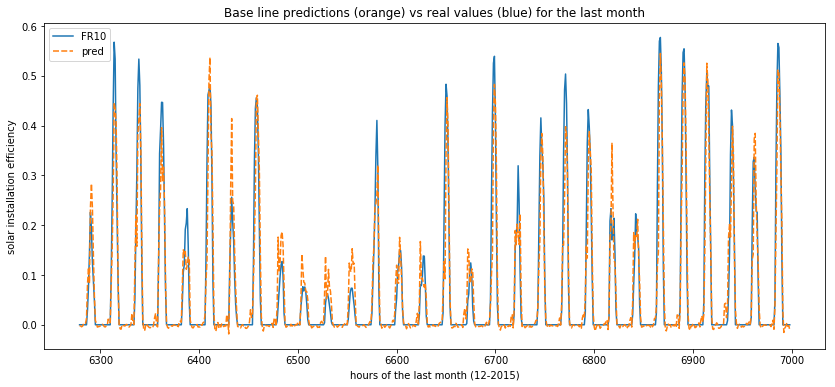

In [27]:
rnn_res = pd.DataFrame(zip(list(y_test), list(np.squeeze(y_pred_test))), columns =['FR10', 'pred'])
plot_predictions(data=rnn_res[-30*24:])

## GRU

More infos on [wikipedia](https://en.wikipedia.org/wiki/Gated_recurrent_unit) or [Towards Data Science](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)

[...]_Gated recurrent units (GRUs) are a gating mechanism in recurrent neural networks, introduced in 2014 by Kyunghyun Cho et al. The GRU is like a long short-term memory (LSTM) with forget gate but has fewer parameters than LSTM, as it lacks an output gate. GRU's performance on certain tasks of polyphonic music modeling and speech signal modeling was found to be similar to that of LSTM. GRUs have been shown to exhibit even better performance on certain smaller datasets._

_However, as shown by Gail Weiss & Yoav Goldberg & Eran Yahav, the LSTM is "strictly stronger" than the GRU as it can easily perform unbounded counting, while the GRU cannot. That's why the GRU fails to learn simple languages that are learnable by the LSTM._

_Similarly, as shown by Denny Britz & Anna Goldie & Minh-Thang Luong & Quoc Le of Google Brain, LSTM cells consistently outperform GRU cells in "the first large-scale analysis of architecture variations for Neural Machine Translation._[...]

In [28]:
from tensorflow.keras.layers import GRU

def my_GRU(input_shape):
    my_GRU = Sequential()
    my_GRU.add(GRU(units=32, return_sequences=True, activation='relu', input_shape=input_shape))
    my_GRU.add(GRU(units=32, activation='relu', return_sequences=False))
    my_GRU.add(Dense(units=1, activation='linear'))
    return my_GRU

gru_model = my_GRU(X.shape[1:])
gru_model.compile(optimizer='adam', loss='mean_squared_error')
gru_model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

Train on 27992 samples, validate on 6999 samples
Epoch 1/50
27992/27992 [==============================] - 26s 932us/sample - loss: 0.0067 - val_loss: 0.0042
Epoch 2/50
27992/27992 [==============================] - 25s 906us/sample - loss: 0.0040 - val_loss: 0.0039
Epoch 3/50
27992/27992 [==============================] - 25s 897us/sample - loss: 0.0037 - val_loss: 0.0040
Epoch 4/50
27992/27992 [==============================] - 25s 886us/sample - loss: 0.0034 - val_loss: 0.0037
Epoch 5/50
27992/27992 [==============================] - 25s 876us/sample - loss: 0.0033 - val_loss: 0.0033
Epoch 6/50
27992/27992 [==============================] - 24s 861us/sample - loss: 0.0033 - val_loss: 0.0034
Epoch 7/50
27992/27992 [==============================] - 24s 863us/sample - loss: 0.0031 - val_loss: 0.0032
Epoch 8/50
27992/27992 [==============================] - 24s 875us/sample - loss: 0.0030 - val_loss: 0.0032
Epoch 9/50
27992/27992 [==============================] - 26s 917us/sample - lo

In [29]:
y_pred_train, y_pred_test = gru_model.predict(X_train), gru_model.predict(X_test)
err_train, err_test = np.sqrt(mean_squared_error(y_train, y_pred_train)), np.sqrt(mean_squared_error(y_test, y_pred_test))
err_train, err_test

(0.042618742983108075, 0.05243714000980988)

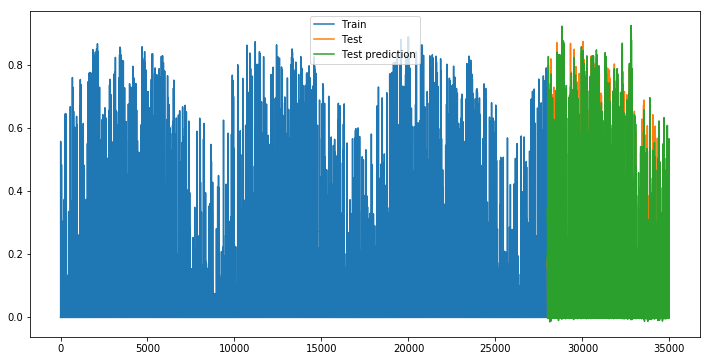

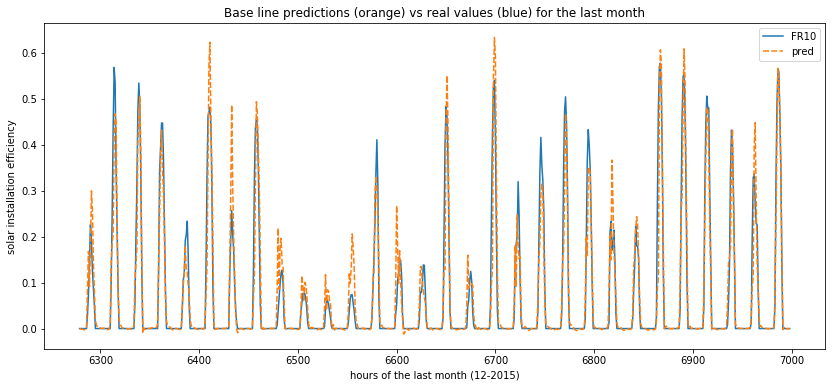

In [30]:
append_results("GRU")
plot_evolution()

gru_res = pd.DataFrame(zip(list(y_test), list(np.squeeze(y_pred_test))), columns =['FR10', 'pred'])
plot_predictions(data=gru_res[-30*24:])

## LSTM

In [31]:
from tensorflow.keras.layers import LSTM

def my_LSTM(input_shape):
    my_LSTM = Sequential()
    my_LSTM.add(LSTM(units=32, return_sequences=True, activation='relu', input_shape=input_shape))
    my_LSTM.add(LSTM(units=32, activation='relu', return_sequences=False))
    my_LSTM.add(Dense(units=1, activation='linear'))
    return my_LSTM

lstm_model = my_LSTM(X.shape[1:])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

Train on 27992 samples, validate on 6999 samples
Epoch 1/50
27992/27992 [==============================] - 31s 1ms/sample - loss: 0.0090 - val_loss: 0.0058
Epoch 2/50
27992/27992 [==============================] - 30s 1ms/sample - loss: 0.0046 - val_loss: 0.0045
Epoch 3/50
27992/27992 [==============================] - 30s 1ms/sample - loss: 0.0039 - val_loss: 0.0038
Epoch 4/50
27992/27992 [==============================] - 31s 1ms/sample - loss: 0.0036 - val_loss: 0.0035
Epoch 5/50
27992/27992 [==============================] - 36s 1ms/sample - loss: 0.0034 - val_loss: 0.0035
Epoch 6/50
27992/27992 [==============================] - 31s 1ms/sample - loss: 0.0033 - val_loss: 0.0034
Epoch 7/50
27992/27992 [==============================] - 31s 1ms/sample - loss: 0.0032 - val_loss: 0.0032
Epoch 8/50
27992/27992 [==============================] - 30s 1ms/sample - loss: 0.0031 - val_loss: 0.0034
Epoch 9/50
27992/27992 [==============================] - 30s 1ms/sample - loss: 0.0031 - val_l

In [32]:
y_pred_train, y_pred_test = lstm_model.predict(X_train), lstm_model.predict(X_test)
err_train, err_test = np.sqrt(mean_squared_error(y_train, y_pred_train)), np.sqrt(mean_squared_error(y_test, y_pred_test))
err_train, err_test

(0.044562709525923214, 0.053767630848682926)

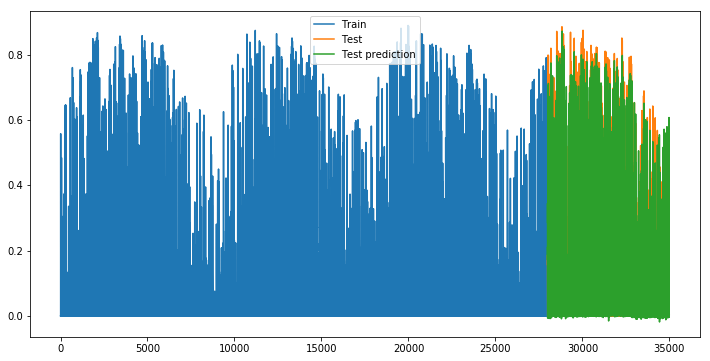

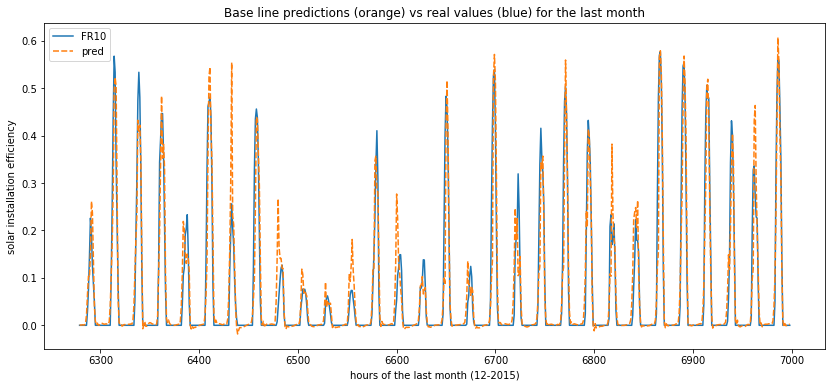

In [33]:
append_results("LSTM")
plot_evolution()

lstm_res = pd.DataFrame(zip(list(y_test), list(np.squeeze(y_pred_test))), columns =['FR10', 'pred'])
plot_predictions(data=lstm_res[-30*24:])

Finally there isn't any huge difference between the forecasts of the 3 types of RNN. We would be intersting to change the number of neurons, of layers, the activation functions and other parameters in order to see if we can make it even more precise. But this is not the goal here.

---

# Conclusions

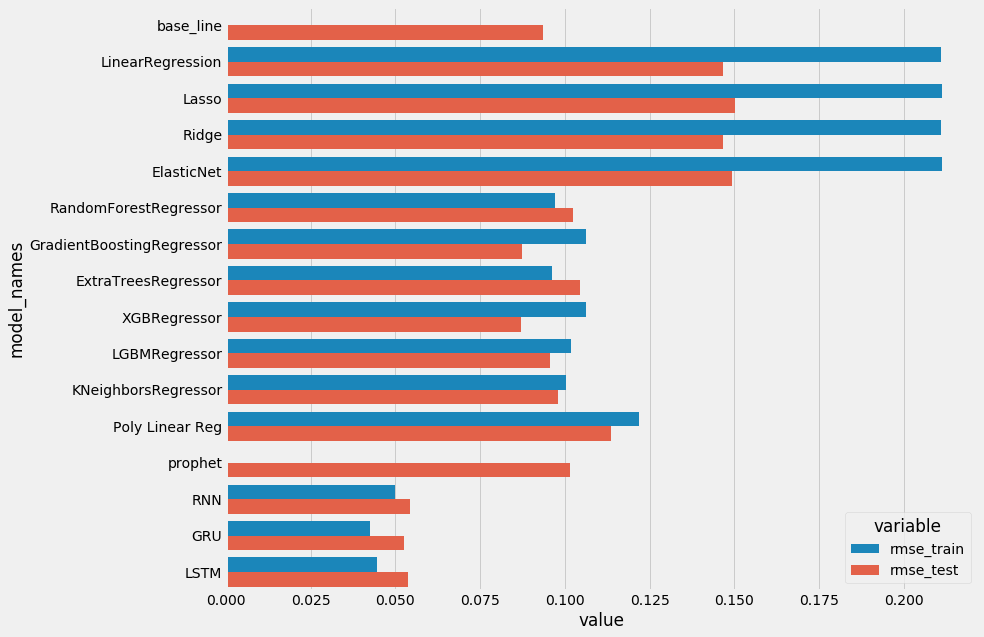

In [35]:
#len(model_names), len(rmse_train), len(rmse_test)

plt.style.use('fivethirtyeight')
plot_scores()

- Linear Regression are under fitting, and don't perform well. Regularizations were not needed here.
- Using Polynomial feature allows us to get better results with no under fitting this time but this is not enough compared to the base line.
- Finally, the boosting familly performs a little better but there isn't any real convincing difference compared to the baseline. It could have been interresting to tune hyperparameters with the RandomizedSearchCV or GridSearchCV methods, but i don't think we'll obtain a real gain.
- Prophet is also not suited here.
__Those models performs well when it comes to get an overall shape but aren't suited when there is a short term change due to the weather on the global tendency. That's why deep learning models are better here.__
Never the less, it should be noted to the R.N.N use the history of the past two days, this can also explain why the last 3 models are more performant. The same history can probably used with other models in order to obtain better forecasts.


On a global perspective :
- The RMSE is around 0.05 compared to values ranging from 0 to 1.
- Anyway it is necessary to relativize because most of the values are under 0.7 and it should be put into perspective that many values are nulls. 
- Finally the RMSE with R.N.N is half the RMSE of the base line which is quite sanguine.
- It could be interesting to tune the parameters of few models to see if we gain few percents...